In [1]:
import os
import keras
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.api.models import load_model, Sequential
from keras.api.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.api.optimizers import Adam
from keras.api.losses import SparseCategoricalCrossentropy
from keras import layers, activations, Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

2024-11-03 00:09:13.398118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 00:09:13.416494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 00:09:13.421684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 00:09:13.434521: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-03 00:09:14.707632: W tensorflow/compiler/tf2

In [2]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 299
img_width   = 299
channel     = 3

image_size              = (img_height, img_width)
image_size_with_channel = (img_height, img_width, channel)

# Constant value
CHECKPOINTS = "checkpoints"
HISTORY = "history"
LATEST_MODEL_NAME = "latest_model.keras"

# Using default sort from VSCode
# Colon polyps, Colorectal cancer, Normal mucosa...
CLASS_ARR = ["Colon polyps", "Colorectal cancer", "Normal mucosa and vascular pattern in the large bowel"]

In [3]:
# Save the current model
def save_model(model, model_name: str = ""):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + ".keras")
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e

In [4]:
def make_evaluation_metrics(model: Model, validation_dataset: tf.data.Dataset):
    predictions = np.array([])
    labels = np.array([])
    categories = CLASS_ARR

    for x, y in validation_dataset:
        y_pred = model.predict(x)
        y_prediction = np.argmax(y_pred, axis=1)
        predictions = np.concatenate([predictions, y_prediction])
        labels = np.concatenate([labels, y.numpy()])

    print("---------------EVALUATION METRICS---------------")

    print(f"Accuracy Score:     {accuracy_score(y_true=labels, y_pred=predictions)}")
    print(f"Precision Score:    {precision_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"Recall Score:       {recall_score(y_true=labels, y_pred=predictions, average=None)}")
    print(f"F1 Score:           {f1_score(y_true=labels, y_pred=predictions, average=None)}")

    print("----------------CONFUSION MATRIX----------------")

    plt.figure(num=69420, figsize=(plt.rcParams.get('figure.figsize')))
    sns.heatmap(confusion_matrix(y_true=labels, y_pred=predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt="d")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

In [5]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_Gastrovision/training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    directory="datasets/preprocessed_Gastrovision/validation",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1942 files belonging to 3 classes.


I0000 00:00:1730567357.820172    9856 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730567357.884366    9856 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730567357.884941    9856 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730567357.886437    9856 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 484 files belonging to 3 classes.


In [6]:
image_augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.2),
        layers.RandomFlip(),
    ])
}

In [7]:
# Pretrained models
inception_model = keras.applications.InceptionV3(
    include_top=False,
    classes=3,
    input_shape=(img_height, img_width, channel)
)

In [8]:
inception_model.trainable = False

for layer in inception_model.layers[-10:]:
    layer.trainable = True

In [9]:
inputs = keras.Input(shape=image_size_with_channel)
x = image_augmentation["training"](inputs)
x = keras.applications.inception_v3.preprocess_input(x)
x = inception_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
x = Dense(128)(x)
x = Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
x = Dense(64)(x)
x = Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
outputs = Dense(units=3, activation=activations.softmax)(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,370,467 (85.34 MB)

 Trainable params: 566,979 (2.16 MB)

 Non-trainable params: 21,803,488 (83.17 MB)

In [10]:
def get_early_stopping():
    return keras.callbacks.EarlyStopping(patience=5)

In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [12]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=10, callbacks=[get_early_stopping()])

Epoch 1/10


2024-11-03 00:09:38.942831: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1730567379.024649    9937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567379.067398    9937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567379.070123    9937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567379.072870    9937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567379.075533    9937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567379.084903    9937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567379.088924    9937 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567379.092027    9937 gpu_t

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.3413 - loss: 1.5348

W0000 00:00:1730567397.261817    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.264061    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.265840    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.268000    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.269977    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.272367    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.274890    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.276981    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567397.279098    9935 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.3419 - loss: 1.5335

W0000 00:00:1730567400.765868    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567400.768089    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567400.770186    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567400.772366    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567400.774257    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567400.785604    9935 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567408.867295    9930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567408.868652    9930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567408.869899    9930 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 48s 445ms/step - accuracy: 0.3425 - loss: 1.5322 - val_accuracy: 0.6818 - val_loss: 0.7809
Epoch 2/10


W0000 00:00:1730567410.726026    9930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567410.727663    9930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567410.729173    9930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730567410.730618    9930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.4548 - loss: 1.2721 - val_accuracy: 0.6653 - val_loss: 0.8625
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 264ms/step - accuracy: 0.5033 - loss: 1.1972 - val_accuracy: 0.6302 - val_loss: 0.9209
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.5479 - loss: 1.0418 - val_accuracy: 0.7045 - val_loss: 0.7966
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.5477 - loss: 1.0833 - val_accuracy: 0.6653 - val_loss: 0.9260
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.5789 - loss: 1.0294 - val_accuracy: 0.7066 - val_loss: 0.7909


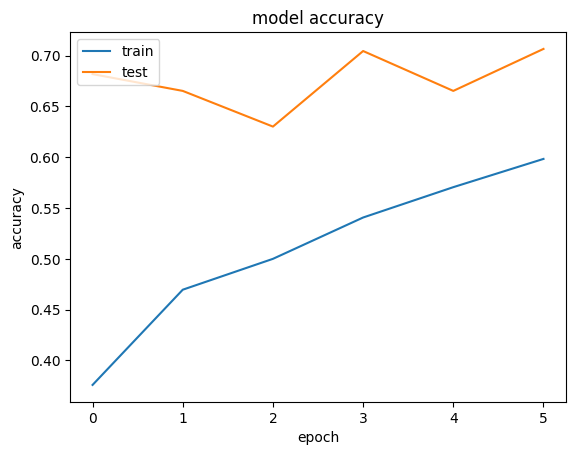

In [17]:
# show training accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

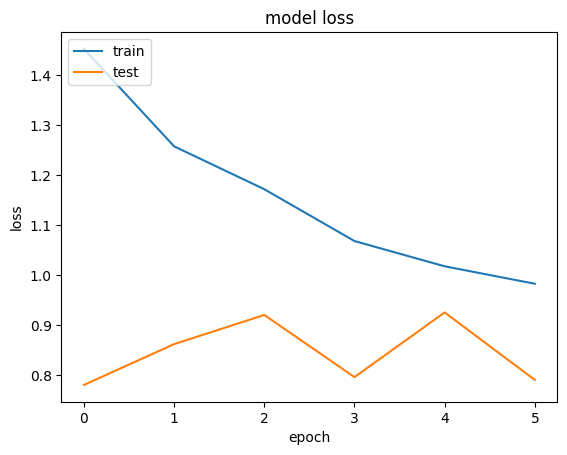

In [14]:
# show training loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# save_model(model, "inceptionv3_feature-extraction")
save_model(model, "inceptionv3_transfer-learning")

Model has succesfully saved


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
---------------EVALUATION METRICS---------------
Accuracy Score:     0.7066115702479339
Precision Score:    [0.56016598 0.45454545 0.87068966]
Recall Score:       [0.82317073 0.18518519 0.6894198 ]
F1 Score:           [0.66666667 0.26315789 0.76952381]
----------------CONFUSION MATRIX----------------


2024-11-03 00:11:43.420075: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


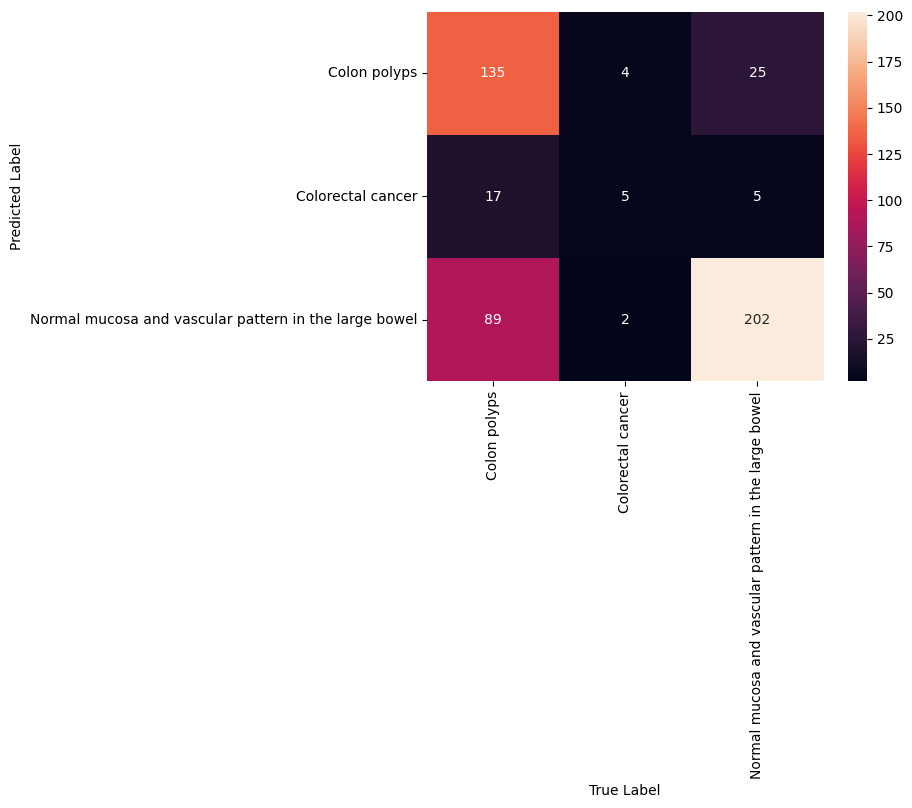

In [16]:
make_evaluation_metrics(model, val_ds)